In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt

# Define Focal Loss
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        
        # Calculate focal loss components
        loss = - alpha * tf.pow((1 - y_pred), gamma) * tf.math.log(y_pred)  # Use tf.math.log
        return tf.keras.backend.mean(tf.keras.backend.sum(loss * y_true, axis=1))  # Use tf.keras.backend.mean
    return focal_loss_fixed

# Define the model
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01), padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=1),  # Change pool size to 1
        Dropout(0.3),

        Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01), padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=1),  # Change pool size to 1
        Dropout(0.3),

        Conv1D(256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01), padding='same'),
        BatchNormalization(),
        # Remove MaxPooling here or change to pool_size=1
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=focal_loss(alpha=.25, gamma=2),
                  metrics=['accuracy'])
    return model


# Load your dataset
file_path = 'cleaned_second_module_input1.csv'  # Update with your file path
data = pd.read_csv(file_path)

# Prepare the data
features = [f'votes_{i}' for i in range(1, 11)] + [f'rating_{i}' for i in range(1, 11)] + ['calculated_score']
X = data[features].values
y = data['predicted_popularity_class'].values

# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the labels
y_encoded = to_categorical(y_encoded)

# Stratified K-Fold Cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store results
histories = []
y_true_all = []
y_pred_all = []

for fold, (train_index, val_index) in enumerate(skf.split(X, np.argmax(y_encoded, axis=1)), 1):
    print(f"Fold {fold}")
    
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y_encoded[train_index], y_encoded[val_index]
    
    # Apply SMOTE
    smote = SMOTE(random_state=42, k_neighbors=2)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Scale features
    scaler = StandardScaler()
    X_train_resampled = scaler.fit_transform(X_train_resampled)
    X_val = scaler.transform(X_val)
    
    X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], X_train_resampled.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    
    # Create and train the model
    model = create_model((21, 1), y_encoded.shape[1])  # Number of classes in one-hot encoded labels
    
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001)
    ]
    
    history = model.fit(X_train_resampled, y_train_resampled,
                        epochs=100,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=callbacks,
                        verbose=0)
    
    histories.append(history)
    
    # Predictions
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    y_true_all.extend(np.argmax(y_val, axis=1))  # Convert one-hot to integers for true labels
    y_pred_all.extend(y_pred_classes)

# Print overall results
print(classification_report(y_true_all, y_pred_all, target_names=label_encoder.classes_))
print(confusion_matrix(y_true_all, y_pred_all))


Fold 1


C:\Users\prade\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Fold 2


C:\Users\prade\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 3


C:\Users\prade\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Fold 4


C:\Users\prade\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 5


C:\Users\prade\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
              precision    recall  f1-score   support

           A       1.00      0.99      1.00       843
          AA       0.95      0.99      0.97       135
           F       1.00      1.00      1.00      2353
           H       0.92      0.96      0.94        48
         SDH       0.80      1.00      0.89         8
          SH       0.00      0.00      0.00         5

    accuracy                           1.00      3392
   macro avg       0.78      0.82      0.80      3392
weighted avg       0.99      1.00      1.00      3392

[[ 838    5    0    0    0    0]
 [   1  133    0    1    0    0]
 [   0    0 2353    0    0    0]
 [   0    2    0   46    0    0]
 [   0    0    0    0    8    0]
 [   0    0    0    3    2    0]]


C:\Users\prade\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\prade\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\prade\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


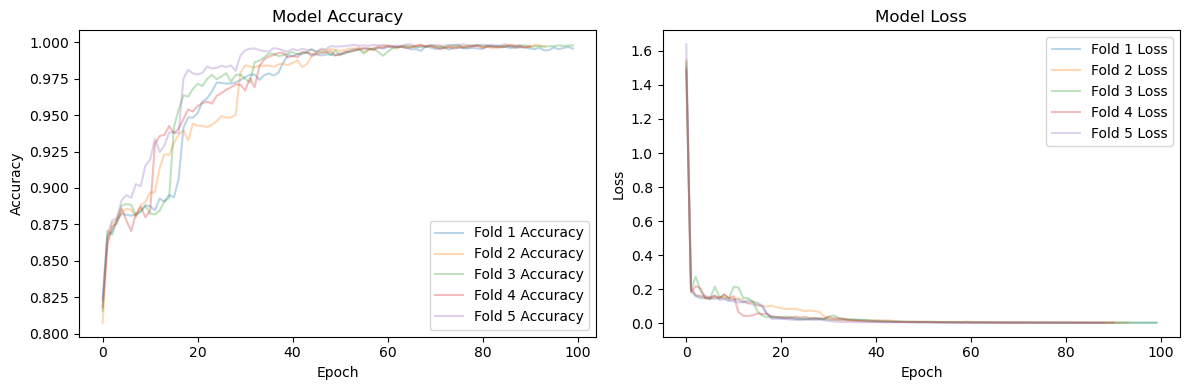

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Plot average learning curves
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
for i, h in enumerate(histories):
    plt.plot(h.history['accuracy'], alpha=0.3, label=f'Fold {i + 1} Accuracy')  # Add label for each fold

# Only average if lengths are consistent
accuracy_lengths = [len(h.history['accuracy']) for h in histories]
if all(length == accuracy_lengths[0] for length in accuracy_lengths):
    avg_accuracy = np.mean([h.history['accuracy'] for h in histories], axis=0)
    plt.plot(avg_accuracy, label='Average Training Accuracy', color='blue')
    avg_val_accuracy = np.mean([h.history['val_accuracy'] for h in histories], axis=0)
    plt.plot(avg_val_accuracy, label='Average Validation Accuracy', color='orange')
else:
    print("Warning: Inconsistent history lengths for accuracy.")

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()  # Call legend to display the labels

# Loss Plot
plt.subplot(1, 2, 2)
for i, h in enumerate(histories):
    plt.plot(h.history['loss'], alpha=0.3, label=f'Fold {i + 1} Loss')  # Add label for each fold

# Only average if lengths are consistent
loss_lengths = [len(h.history['loss']) for h in histories]
if all(length == loss_lengths[0] for length in loss_lengths):
    avg_loss = np.mean([h.history['loss'] for h in histories], axis=0)
    plt.plot(avg_loss, label='Average Training Loss', color='blue')
    avg_val_loss = np.mean([h.history['val_loss'] for h in histories], axis=0)
    plt.plot(avg_val_loss, label='Average Validation Loss', color='orange')
else:
    print("Warning: Inconsistent history lengths for loss.")

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  # Call legend to display the labels

plt.tight_layout()
plt.show()
